# Demonstrate construction and quantization of a model for execution on the EdgeTPU

This MNIST example should be helpful:  
https://www.tensorflow.org/lite/performance/post_training_integer_quant  

This webpage, and links at the bottom of the page, may also be helpful:  
https://www.tensorflow.org/lite/performance/post_training_quantization

## See of some of these comments help too:  
https://github.com/google-coral/edgetpu/issues/13

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, SeparableConv2D, \
                                    Dense, ReLU, Reshape, Dropout, Flatten

import time

# %matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
## Print out some system information
import subprocess

print('Linux kernel version:')
print('$ uname -r')
result = subprocess.run(['uname', '-r'], stdout=subprocess.PIPE)
print(result.stdout.decode('utf-8'))

print('Linux release:')
print('$ lsb_release -a')
result = subprocess.run(['lsb_release', '-a'], stdout=subprocess.PIPE)
print(result.stdout.decode('utf-8'))

print('Tensorflow python module version')
print(tf.__version__)
print('')

print('Edge TPU python module version:')
import edgetpu
print(edgetpu.__version__)
print('')

print('Edge TPU compiler version:')
result = subprocess.run(['edgetpu_compiler', '--version'], stdout=subprocess.PIPE)
print(result.stdout.decode('utf-8'))
print('')

print('Edge TPU runtime file:')
result = subprocess.check_output("dpkg -l | grep libedgetpu", shell=True)
print(result.decode("utf-8"))

print('Edge TPU runtime version:')
import edgetpu.basic.edgetpu_utils
print(edgetpu.basic.edgetpu_utils.GetRuntimeVersion())

# import tflite_runtime.interpreter as tflite
import tflite_runtime
print('tflite_runtime version:')
print(tflite_runtime.__version__)
print('')

print('Paths of available Edge TPU devices, if any:')
devices = edgetpu.basic.edgetpu_utils.ListEdgeTpuPaths(edgetpu.basic.edgetpu_utils.EDGE_TPU_STATE_NONE)
print(devices)
# Set identity of edge device to use, if any
if len(devices) > 0:
    # Use the first device in the list
    if devices[0].startswith('/dev/apex'):
        target_device = 'pci'
    else:
        # Assuming device is on USB bus
        target_device = 'usb'
    print('Using delegate device: "%s"' % (target_device))

Linux kernel version:
$ uname -r
4.15.0-76-generic

Linux release:
$ lsb_release -a
Distributor ID:	Ubuntu
Description:	Ubuntu 18.04.4 LTS
Release:	18.04
Codename:	bionic

Tensorflow python module version
2.1.0

Edge TPU python module version:
2.13.0

Edge TPU compiler version:
Edge TPU Compiler version 2.0.291256449


Edge TPU runtime file:
ii  libedgetpu1-max:amd64                           13.0                                                amd64        Support library for Edge TPU

Edge TPU runtime version:
BuildLabel(COMPILER=5.4.0 20160609,DATE=redacted,TIME=redacted,CL_NUMBER=291256449), RuntimeVersion(13)
tflite_runtime version:
2.1.0

Paths of available Edge TPU devices, if any:
('/dev/apex_0', '/sys/bus/usb/devices/1-10')
Using delegate device: "pci"


In [3]:
if tf.__version__.startswith('1.15'):
    # This prevents some errors that otherwise occur when converting the model with TF 1.15...
    tf.enable_eager_execution() # Only if TF is version 1.15    

In [4]:
## Build a very simple model

# Include whichever type of layer(s) you want to test out.
x = Input(name='input', shape=(28, 28), dtype='float32')
y = Reshape((28, 28, 1))(x)
y = Conv2D(32, kernel_size=(3, 3), activation='relu')(y)
y = Conv2D(64, (3, 3), activation='relu')(y)
# y = SeparableConv2D(32, kernel_size=(3, 3), activation='relu')(y)
# y = SeparableConv2D(64, (3, 3), activation='relu')(y)
y = MaxPooling2D(pool_size=(2, 2))(y)
# y = Dropout(0.25)(y)
y = Flatten()(y)
y = Dense(128, activation='relu')(y)
# y = Dropout(0.5)(y)
y = Dense(10)(y)
model = Model(inputs=x, outputs=y)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 28, 28)]          0         
_________________________________________________________________
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               117977

In [5]:
## Get MNIST data

mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Normalize the input image so that each pixel value is between 0 to 1.
train_images = train_images / 255.0
test_images = test_images / 255.0

Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 31s 509us/sample - loss: 0.1094 - accuracy: 0.9666 - val_loss: 0.0390 - val_accuracy: 0.9878
Epoch 2/2
60000/60000 [==============================] - 30s 508us/sample - loss: 0.0336 - accuracy: 0.9893 - val_loss: 0.0467 - val_accuracy: 0.9851


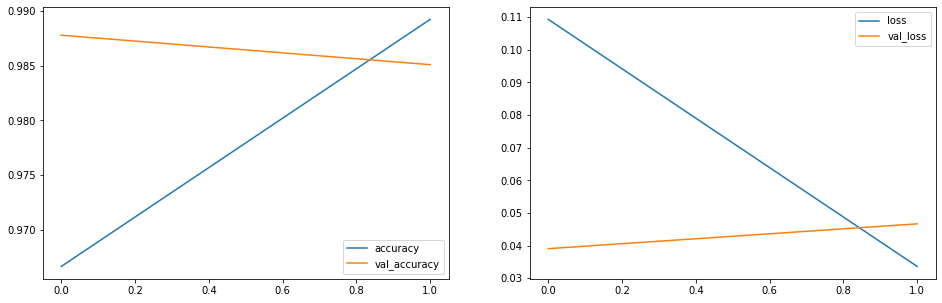

In [6]:
# Train the MNIST model
model.compile(optimizer='adam',
              loss=SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model.fit(
  train_images,
  train_labels,
  epochs=2,
  validation_data=(test_images, test_labels)
)

plt.figure(figsize=(16, 5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])

In [7]:
# Convert to a tflite model, with unquantized parameters.

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open('mnist_model_unquantized.tflite', 'wb').write(tflite_model)

4801824

In [8]:
## Convert to tflite quantized model. Parameters are quantized, but model
## still runs with float32 operations.

def representative_dataset_gen():
    images = tf.cast(train_images, tf.float32)
    mnist_ds = tf.data.Dataset.from_tensor_slices((images)).batch(1)
    for input_value in mnist_ds.take(100):
        yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
# converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
converter.representative_dataset = tf.lite.RepresentativeDataset(representative_dataset_gen)

tflite_model = converter.convert()
open('mnist_model_quantized.tflite', 'wb').write(tflite_model)

1206896

In [9]:
## Convert to tflite quantized model for EdgeTPU.
## Parameters are quantized, and model operations are uint8.

def representative_dataset_gen():
    images = tf.cast(train_images, tf.float32)
    mnist_ds = tf.data.Dataset.from_tensor_slices((images)).batch(1)
    for input_value in mnist_ds.take(100):
        yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
# converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
converter.representative_dataset = tf.lite.RepresentativeDataset(representative_dataset_gen)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8] # For EdgeTPU, no float ops allowed
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_model = converter.convert()
open('mnist_model_quantized_io.tflite', 'wb').write(tflite_model)

1206896

In [10]:
%%bash
## Compile model for edge TPU
# Note that the output file name has '_edgetpu' appended to the root filename of the input TFLite model.
edgetpu_compiler --min_runtime_version 13 --show_operations 'mnist_model_quantized_io.tflite'

Edge TPU Compiler version 2.0.291256449

Model compiled successfully in 39 ms.

Input model: mnist_model_quantized_io.tflite
Input size: 1.15MiB
Output model: mnist_model_quantized_io_edgetpu.tflite
Output size: 1.21MiB
On-chip memory available for caching model parameters: 7.84MiB
On-chip memory used for caching model parameters: 34.00KiB
Off-chip memory used for streaming uncached model parameters: 1.13MiB
Number of Edge TPU subgraphs: 1
Total number of operations: 8
Operation log: mnist_model_quantized_io_edgetpu.log

Model successfully compiled but not all operations are supported by the Edge TPU. A percentage of the model will instead run on the CPU, which is slower. If possible, consider updating your model to use only operations supported by the Edge TPU. For details, visit g.co/coral/model-reqs.
Number of operations that will run on Edge TPU: 6
Number of operations that will run on CPU: 2

Operator                       Count      Status

QUANTIZE                       1       

In [11]:
# Load all four models into interpreters

# Float 32
interpreter = tf.lite.Interpreter(model_path='mnist_model_unquantized.tflite')
interpreter.allocate_tensors()
input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

# Quantized
interpreter_quant = tf.lite.Interpreter(model_path='mnist_model_quantized.tflite')
interpreter_quant.allocate_tensors()
input_index_quant = interpreter_quant.get_input_details()[0]["index"]
output_index_quant = interpreter_quant.get_output_details()[0]["index"]

# Quantized, including input and output
interpreter_quant_io = tf.lite.Interpreter(model_path='mnist_model_quantized_io.tflite')
interpreter_quant_io.allocate_tensors()
input_index_quant_io = interpreter_quant_io.get_input_details()[0]["index"]
output_index_quant_io = interpreter_quant_io.get_output_details()[0]["index"]

# Quantized for EdgeTPU
import tflite_runtime.interpreter as tfl_run_interp
interpreter_edgetpu = tfl_run_interp.Interpreter(model_path='mnist_model_quantized_io_edgetpu.tflite',
                          model_content=None,
                          experimental_delegates=[tfl_run_interp.load_delegate('libedgetpu.so.1.0',
                                                                               {'device': target_device})])

interpreter_edgetpu.allocate_tensors()
input_index_edgetpu = interpreter_edgetpu.get_input_details()[0]["index"]
output_index_edgetpu = interpreter_edgetpu.get_output_details()[0]["index"]

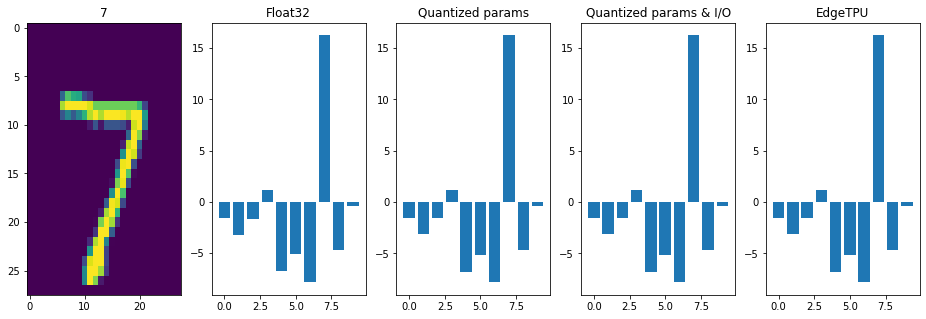

In [16]:
# Test
i_im = 0
test_image_float32 = np.expand_dims(test_images[i_im], axis=0).astype(np.float32)

interpreter.set_tensor(input_index, test_image_float32)
interpreter.invoke()
predictions = interpreter.get_tensor(output_index)

interpreter_quant.set_tensor(input_index_quant, test_image_float32)
interpreter_quant.invoke()
predictions_quant = interpreter_quant.get_tensor(output_index_quant)

interpreter_quant_io.set_tensor(input_index_quant_io, test_image_float32)
interpreter_quant_io.invoke()
predictions_quant_io = interpreter_quant_io.get_tensor(output_index_quant_io)

interpreter_edgetpu.set_tensor(input_index_edgetpu, test_image_float32)
interpreter_edgetpu.invoke()
predictions_edgetpu = interpreter_edgetpu.get_tensor(output_index_edgetpu)

plt.figure(figsize=(16, 5))

plt.subplot(1,5,1)
plt.imshow(test_image_float32[0])
plt.title(str(test_labels[i_im]))

plt.subplot(1,5,2)
plt.bar(np.arange(10), predictions[0])
plt.title('Float32')

plt.subplot(1,5,3)
plt.bar(np.arange(10), predictions_quant[0])
plt.title('Quantized params')

plt.subplot(1,5,4)
plt.bar(np.arange(10), predictions_quant_io[0])
plt.title('Quantized params & I/O')

plt.subplot(1,5,5)
plt.bar(np.arange(10), predictions_edgetpu[0])
_ = plt.title('EdgeTPU')

In [13]:
## Test the processing speeds

n_test_images = 100

# Float 32 model
t_start = time.time()
predictions = np.zeros((n_test_images, 10))
for i_im in range(n_test_images):
    interpreter.set_tensor(input_index,
                           np.expand_dims(test_images[i_im], axis=0).astype(np.float32))
    interpreter.invoke()
    predictions[i_im, :] = interpreter.get_tensor(output_index)
t_process = time.time() - t_start
acc = np.mean(np.argmax(predictions, axis=1)==test_labels[:n_test_images])
print('Float32 model processed %d images in %f seconds. Accuracy=%0.2f%%.' % (n_test_images, t_process, acc*100))

# Quantized model on CPU
t_start = time.time()
predictions = np.zeros((n_test_images, 10))
for i_im in range(n_test_images):
    interpreter_quant.set_tensor(input_index_quant_io,
                                 np.expand_dims(test_images[i_im], axis=0).astype(np.float32))
    interpreter_quant.invoke()
    predictions[i_im, :] = interpreter_quant.get_tensor(output_index_quant)
t_process = time.time() - t_start
acc = np.mean(np.argmax(predictions, axis=1)==test_labels[:n_test_images])
print('Quantized model processed %d images in %f seconds. Accuracy=%0.2f%%.' % (n_test_images, t_process, acc*100))

# Quantized model on CPU, include I/O
t_start = time.time()
predictions = np.zeros((n_test_images, 10))
for i_im in range(n_test_images):
    interpreter_quant_io.set_tensor(input_index_quant_io,
                                    np.expand_dims(test_images[i_im], axis=0).astype(np.float32))
    interpreter_quant_io.invoke()
    predictions[i_im, :] = interpreter_quant_io.get_tensor(output_index_quant_io)
t_process = time.time() - t_start
acc = np.mean(np.argmax(predictions, axis=1)==test_labels[:n_test_images])
print('Quantized I/O model processed %d images in %f seconds. Accuracy=%0.2f%%.' % (n_test_images, t_process, acc*100))

# Quantized model on EdgeTPU
t_start = time.time()
predictions = np.zeros((n_test_images, 10))
for i_im in range(n_test_images):
    interpreter_edgetpu.set_tensor(input_index_edgetpu,
                                    np.expand_dims(test_images[i_im], axis=0).astype(np.float32))
    interpreter_edgetpu.invoke()
    predictions[i_im, :] = interpreter_edgetpu.get_tensor(output_index_edgetpu)
t_process = time.time() - t_start
acc = np.mean(np.argmax(predictions, axis=1)==test_labels[:n_test_images])
print('EdgeTPU model processed %d images in %f seconds. Accuracy=%0.2f%%.' % (n_test_images, t_process, acc*100))


Float32 model processed 100 images in 0.037049 seconds. Accuracy=99.00%.
Quantized model processed 100 images in 1.946991 seconds. Accuracy=99.00%.
Quantized I/O model processed 100 images in 1.931754 seconds. Accuracy=99.00%.
EdgeTPU model processed 100 images in 0.320166 seconds. Accuracy=99.00%.
